In [329]:
import urllib2

import nltk
import numpy as np
import pandas as pd

from keras import models, layers, optimizers, backend
from seaborn import plt

%matplotlib inline
from IPython.core.pylabtools import figsize

In [3]:
moby_url = "http://www.gutenberg.org/files/2701/2701.txt"
moby_txt = urllib2.urlopen(moby_url).read()

In [393]:
class BytePairEncoder(object):
    
    def __init__(
            self,
            max_vocab_size=None, vocab_size_heuristic_cutoff=2,
            freq_transform=lambda x: np.maximum(x, 0),
            normalizer=lambda s: s, tokenizer=nltk.tokenize.casual_tokenize):
        self._max_vocab_size = max_vocab_size
        self._vocab_size_heuristic_cutoff = vocab_size_heuristic_cutoff
        self._freq_transform = freq_transform
        self._normalizer = normalizer
        self._tokenizer = tokenizer
        self._word_freqs = {}
        self._pairs_to_words = {}
        self._pairs_to_freqs = {}
        self._code_children = {}
        self._word_reprs = {}
        self._next_code = 0
        self._decoder = {}
        self._encoder = {}
        self._unk = None
        self._largest_width = 0
        
    def _infer_max_vocab_size(self, raw_freqs):
        self._max_vocab_size = (raw_freqs > self._vocab_size_heuristic_cutoff).sum()

    def _compile_dictionary(self, x):
        x = self._normalizer(x)
        raw_freqs = pd.Series(self._tokenizer(x)).value_counts()
        if self._max_vocab_size is None:
            self._infer_max_vocab_size(raw_freqs)
        self._word_freqs = dict(self._freq_transform(raw_freqs))
        self._code_children = dict(enumerate(set(x)))
        self._next_code = max(self._code_children.keys()) + 1
        char_encoder = dict((v, k) for k, v in self._code_children.items())
        self._word_reprs = dict([
            (word, [char_encoder[char] for char in word])
            for word in self._word_freqs])

    def _iterpairs(self, wrepr):
        return (p for p in zip(wrepr[:-1], wrepr[1:]) if len(p) == 2)
    
    def _index_pair_in_word(self, pair, word, freq=None):
        if freq is None:
            freq = self._word_freqs[word]
        if pair not in self._pairs_to_words:
            self._pairs_to_words[pair] = set()
        self._pairs_to_words[pair].add(word)
        if pair not in self._pairs_to_freqs:
            self._pairs_to_freqs[pair] = 0
        self._pairs_to_freqs[pair] += freq

    def _index_codepairs(self):
        self._pairs_to_words = {}
        self._pairs_to_freqs = {}
        for word, freq in self._word_freqs.iteritems():
            wrepr = self._word_reprs[word]
            for pair in self._iterpairs(wrepr):
                self._index_pair_in_word(pair, word, freq)

    def _top_pair(self):
        return max(
            self._pairs_to_freqs.iterkeys(),
            key=lambda k: self._pairs_to_freqs[k])

    def _expand_vocab(self):
        top = self._top_pair()
        code = self._next_code
        self._next_code += 1
        del self._pairs_to_freqs[top]
        self._code_children[code] = top
        for word in self._pairs_to_words[top]:
            self._merge_in_word(word, top, code)

    def _finalize_vocab(self):
        for code in np.arange(self._max_vocab_size):
            children = self._code_children[code]
            if isinstance(children, str):
                self._decoder[code] = children
            else:
                decoding = ""
                for child in children:
                    if isinstance(child, str):
                        decoding += child
                    else:
                        decoding += self._decoder[child]
                self._decoder[code] = decoding
        self._encoder = dict((v, k) for k, v in self._decoder.iteritems())
        self._unk = self._max_vocab_size + 1
        self._decoder[self._unk] = ":UNK:"
        self._largest_width = max(len(w) for w in self._encoder)

    def _build_vocab(self):
        while self._next_code <= self._max_vocab_size:
            self._expand_vocab()
        self._finalize_vocab()
    
    def _deindex_pair_in_word(self, pair, word):
        freq = self._word_freqs[word]
        self._pairs_to_words[pair].discard(word)
        self._pairs_to_freqs[pair] -= freq
    
    def _merge_in_word(self, word, old_pair, new_code):
        wrepr = self._word_reprs[word]
        pairs_before = set(self._iterpairs(wrepr))
        new_wrepr = []
        left = wrepr[0]
        for right in wrepr[1:]:
            if (left, right) == old_pair:
                new_wrepr.append(new_code)
                left = new_code
            else:
                if left != new_code:
                    new_wrepr.append(left)
                left = right
        if left != new_code:
            new_wrepr.append(right)
        self._word_reprs[word] = new_wrepr
        pairs_after = set(self._iterpairs(new_wrepr))
        for novel_pair in pairs_after - pairs_before:
            self._index_pair_in_word(novel_pair, word)
        for extinct_pair in pairs_before - pairs_after - set([old_pair]):
            self._deindex_pair_in_word(extinct_pair, word)

    def _encoding_step(self, x):
        for width in self._largest_width - np.arange(self._largest_width):
            chunk = x[:width]
            code = self._encoder.get(chunk)
            if code is not None:
                return code, width
        return self._unk, 1
    
    def fit(self, x):
        self._compile_dictionary(x)
        self._index_codepairs()
        self._build_vocab()
        return self

    def encode(self, x):
        x = self._normalizer(x)
        encoded = []
        i = 0
        while i < len(x):
            code, width = self._encoding_step(x[i:])
            encoded.append(code)
            i += width
        return np.array(encoded)
    
    def decode(self, x, include_boundaries=False):
        join_char = "|" * include_boundaries
        return join_char.join(self._decoder[code] for code in x)
    
    def segment(self, x):
        return self.decode(self.encode(x), include_boundaries=True)
    
    def transform(self, x):
        return np.array([self.encode(sent) for sent in x])
    
    def inverse_transform(self, x):
        return np.array([self.decode(sent) for sent in x])

In [394]:
bpe = BytePairEncoder().fit(moby_txt)

In [395]:
lbpe = BytePairEncoder(freq_transform=np.log).fit(moby_txt)

In [396]:
ubpe = BytePairEncoder(freq_transform=lambda freq: np.minimum(freq, 1)).fit(moby_txt)

In [397]:
bpe.segment("Good heavens, whatever can have come over you on this morning?")

'Good| |heavens|,| |whatever| |can| |have| |come| |over| |you| |on| |this| |morning|?'

In [398]:
lbpe.segment("Good heavens, whatever can have come over you on this morning?")

'Good| |heavens|,| |whatever| |can| |have| |come| |over| |you| |on| |this| |morning|?'

In [399]:
ubpe.segment("Good heavens, whatever can have come over you on this morning?")

'Good| |heaven|s|,| |what|ever| |can| |hav|e| |come| |over| |you| |on| |this| |morn|ing|?'

In [400]:
fs = pd.Series(bpe._word_freqs)
freqs = pd.DataFrame({"word": fs.index, "freq": fs})
freqs.sort_values("freq", ascending=False, inplace=True)
freqs.reset_index(drop=True, inplace=True)
freqs["bpe"] = freqs.word.map(bpe.segment)
freqs["lbpe"] = freqs.word.map(lbpe.segment)
freqs["ubpe"] = freqs.word.map(ubpe.segment)
freqs["n_bpe"] = freqs.word.map(bpe.encode).map(len)
freqs["n_lbpe"] = freqs.word.map(lbpe.encode).map(len)
freqs["n_ubpe"] = freqs.word.map(ubpe.encode).map(len)

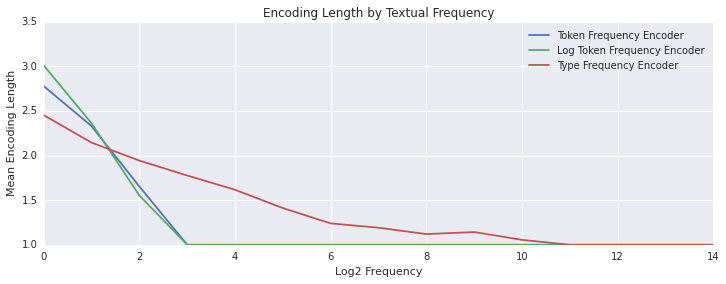

In [417]:
figsize(12, 4)
to_plot = freqs.groupby(np.log2(freqs.freq).astype(int)).mean()[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Log2 Frequency")
plt.ylabel("Mean Encoding Length")
plt.title("Encoding Length by Textual Frequency")
plt.show()

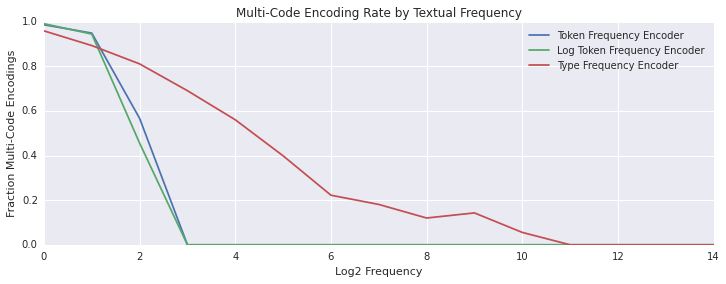

In [418]:
to_plot = freqs.groupby(np.log2(freqs.freq).astype(int)).agg(lambda x: np.mean(x > 1))[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Log2 Frequency")
plt.ylabel("Fraction Multi-Code Encodings")
plt.title("Multi-Code Encoding Rate by Textual Frequency")
plt.show()